### Import Modules and Libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

#### Reading Data

In [8]:
data = pd.read_csv('C:/Users/bhave/Downloads/training_variants/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Training/ training_variants is a csv file containing the description of genetic mutations used for training.

ID : id of the row used to link the mutation to the clinical evidence 

Gene : the gene where this genetic mutation is located 

Variation : the aminoacid change for this mutations 

Class : 1-9 classes this genetic mutation has been classified on

#### Read Text Data

In [45]:
data_text =pd.read_csv("C:/Users/bhave/Downloads/training_text/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [82]:
data_text.isnull()
data_text[data_text.TEXT.isnull()]

,ID,TEXT


In [85]:
data[data.Variation.isnull()]

,ID,Gene,Variation,Class


### Text Pre-Processing

In [47]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
            # if word is not a stop word, retain that word from data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [48]:
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 146.26607857223553 seconds


In [88]:
#Merge both gene_variations and text data based on ID

result = pd.merge(data, data_text,on='ID', how='left')
result.head()

result['TEXT'].fillna(value = "Gene Variation", inplace = True)
result[result.TEXT.isnull()]

,ID,Gene,Variation,Class,TEXT


#### Split Data into Train, Test and Cross Validation (64: 20: 16)

In [89]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2125
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### Class Distribution in Train, Test and Cross Validation Datasets

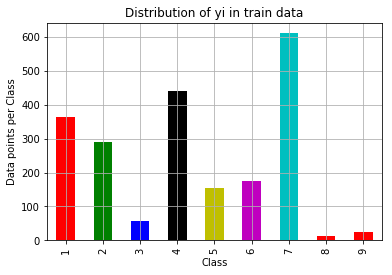

Number of data points in class 7 : 610 ( 28.706 %)
Number of data points in class 4 : 439 ( 20.659 %)
Number of data points in class 1 : 363 ( 17.082 %)
Number of data points in class 2 : 289 ( 13.6 %)
Number of data points in class 6 : 176 ( 8.282 %)
Number of data points in class 5 : 155 ( 7.294 %)
Number of data points in class 3 : 57 ( 2.682 %)
Number of data points in class 9 : 24 ( 1.129 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


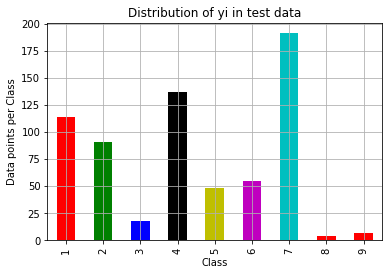

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


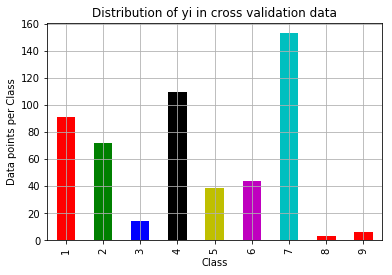

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [91]:
# Returns a dict, keys as class labels and values as the number of data points in that class

train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = ['r','g','b','k','y','m','c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


# -(train_class_distribution.values): the negative sign gives us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['r','g','b','k','y','m','c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = ['r','g','b','k','y','m','c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


### Random Model Prediction:

In [92]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
   
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5118627821370247
Log loss on Test Data using Random Model 2.526232695981823
-------------------- Confusion matrix --------------------


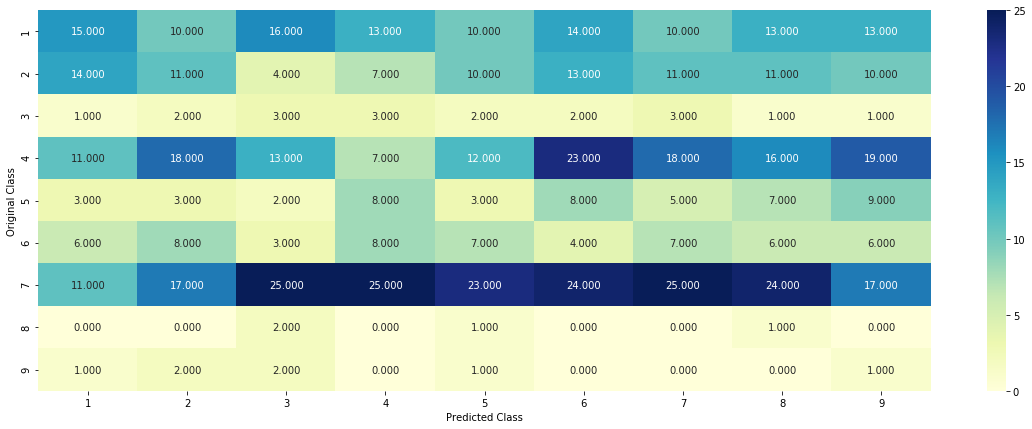

-------------------- Precision matrix (Columm Sum=1) --------------------


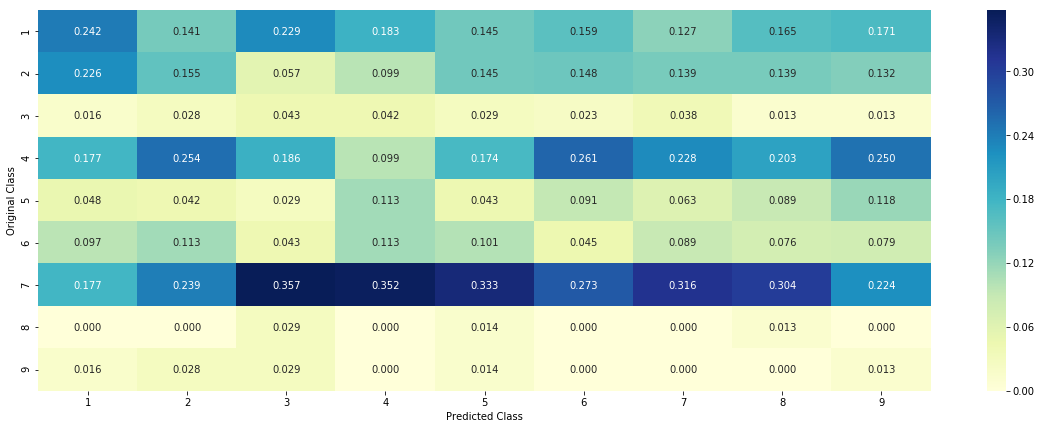

-------------------- Recall matrix (Row sum=1) --------------------


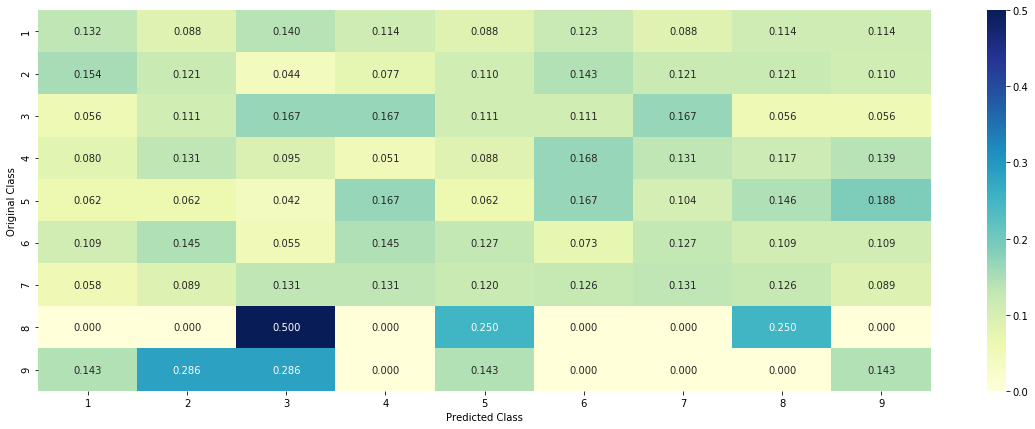

In [53]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

### Univariate Analysis

In [93]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator contains the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec contains (p(yi==1/Gi) probability of gene/variation to particular class

        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # Adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, contains the feature for each feature value in the data
    gv_fea = []
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
            
    return gv_fea

To Calculate the probability of a feature belonging to any class, Laplace Smoothing is applied.
(numerator + 10 * alpha) / (denominator + 90 * alpha)

### Univariate Analysis on Gene Feature

In [94]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data",)
print("Distribution of categories are as follows: ")

Number of Unique Genes : 231
BRCA1     173
TP53      100
EGFR       93
PTEN       85
BRCA2      79
KIT        62
BRAF       59
ERBB2      47
ALK        46
PDGFRA     43
Name: Gene, dtype: int64
Ans: There are 231 different categories of genes in the train data
Distribution of categories are as follows: 


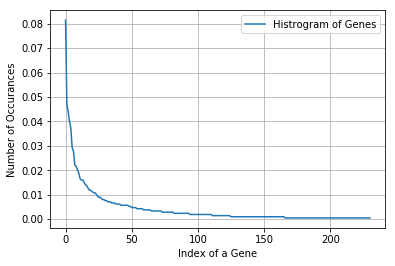

In [95]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

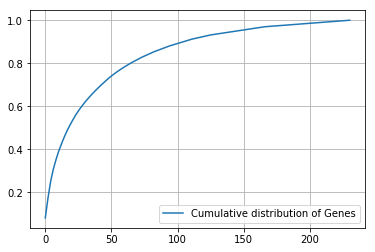

In [96]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [97]:
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [98]:
print("train_gene_feature_response_Coding is converted feature\
 using respone coding method. \n The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_response_Coding is converted feature using respone coding method. 
 The shape of gene feature: (2125, 9)


In [99]:
# one-hot encoding of Gene feature.

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [100]:
train_df['Gene'].head()

475      TP53
2772     BRAF
798     ERBB4
2345     JAK2
2704     BRAF
Name: Gene, dtype: object

In [101]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1

In [102]:
print("train_gene_feature_onehotCoding is converted feature \
using one-hot encoding method. \n The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. 
 The shape of gene feature: (2125, 230)


For values of alpha =  1e-05 The log loss is: 1.4185597294146888
For values of alpha =  0.0001 The log loss is: 1.2537058375383912
For values of alpha =  0.001 The log loss is: 1.2495901363194395
For values of alpha =  0.01 The log loss is: 1.339622573289618
For values of alpha =  0.1 The log loss is: 1.4381484488219267
For values of alpha =  1 The log loss is: 1.479168786713769


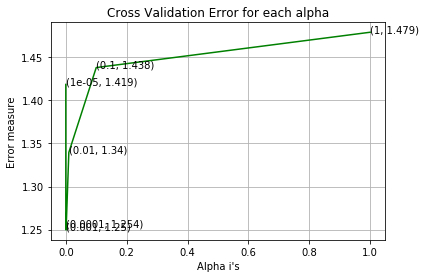

For values of best alpha =  0.001 The train log loss is: 1.1001778526234127
For values of best alpha =  0.001 The cross validation log loss is: 1.2495901363194395
For values of best alpha =  0.001 The test log loss is: 1.2063348935424418


In [103]:
alpha = [10 ** x for x in range(-5, 1)]   # hyperparameter for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Univariate Analysis on Variation Feature

In [104]:
unique_variations = train_df['Variation'].value_counts()

print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data.")
print("Distribution of Categories are as follows: ")

Number of Unique Variations : 1932
Truncating_Mutations    62
Amplification           43
Deletion                41
Fusions                 27
Overexpression           5
G12V                     3
R841K                    2
G13C                     2
E17K                     2
Q61L                     2
Name: Variation, dtype: int64
Ans: There are 1932 different categories of variations in the train data.
Distribution of Categories are as follows: 


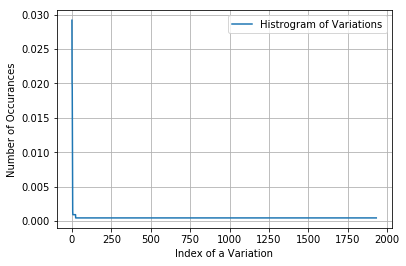

In [105]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02917647 0.04941176 0.06870588 ... 0.99905882 0.99952941 1.        ]


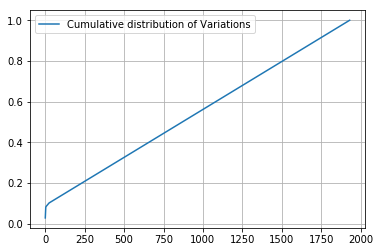

In [106]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [107]:
alpha = 1

# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))

# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))

# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [108]:
# one-hot encoding of variation feature.

variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

For values of alpha =  1e-05 The log loss is: 1.7222267412464067
For values of alpha =  0.0001 The log loss is: 1.7020584943083883
For values of alpha =  0.001 The log loss is: 1.7033819584940992
For values of alpha =  0.01 The log loss is: 1.7145621375895062
For values of alpha =  0.1 The log loss is: 1.7205175103609294
For values of alpha =  1 The log loss is: 1.7193343752276014


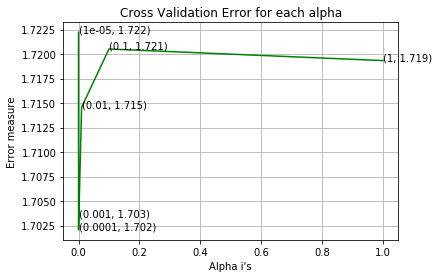

For values of best alpha =  0.0001 The train log loss is: 0.7063410391436301
For values of best alpha =  0.0001 The cross validation log loss is: 1.7020584943083883
For values of best alpha =  0.0001 The test log loss is: 1.7182198032276321


In [110]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Univariate Analysis on Text Feature

In [111]:
# cls_text: data frame
# for every row in data frame, consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [112]:
# Credits: https://stackoverflow.com/a/1602964

import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [113]:
# Building a CountVectorizer with all the words that occured minimum 3 times in train data


text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52703


In [114]:
dict_list = []

# dict_list =[] contains 9 dictoinaries each corresponds to a class

for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))

total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [115]:
#response coding of text features

train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

# Normalizing the features
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# Normalizing the features
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# Normalizing the features
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [116]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))
print(Counter(sorted_text_occur))

Counter({3: 5191, 4: 3529, 5: 2639, 6: 2626, 8: 2266, 7: 2011, 9: 1869, 12: 1467, 10: 1423, 11: 1009, 14: 963, 16: 890, 15: 883, 13: 843, 18: 774, 20: 672, 17: 571, 24: 566, 21: 562, 19: 471, 22: 435, 28: 389, 42: 372, 23: 366, 25: 363, 27: 362, 30: 359, 26: 332, 36: 331, 29: 322, 32: 302, 47: 301, 34: 243, 31: 240, 35: 231, 40: 221, 39: 213, 33: 212, 48: 209, 37: 199, 45: 194, 41: 183, 43: 175, 52: 164, 44: 162, 38: 159, 46: 156, 50: 152, 49: 149, 60: 147, 54: 147, 51: 145, 58: 132, 59: 130, 57: 128, 56: 126, 72: 125, 55: 123, 53: 120, 69: 117, 63: 110, 61: 109, 94: 107, 68: 106, 66: 104, 64: 103, 62: 103, 84: 92, 70: 90, 65: 85, 80: 84, 75: 80, 71: 80, 67: 80, 76: 79, 88: 73, 81: 71, 78: 71, 74: 71, 85: 70, 79: 70, 77: 70, 90: 68, 86: 67, 97: 66, 96: 66, 73: 66, 100: 63, 89: 63, 82: 62, 83: 61, 104: 59, 95: 59, 99: 58, 87: 58, 92: 56, 91: 56, 110: 55, 105: 55, 102: 54, 109: 53, 101: 53, 98: 53, 115: 51, 141: 50, 107: 50, 103: 50, 128: 49, 93: 49, 106: 48, 118: 47, 129: 46, 111: 45, 1

#### Logistic Regression + Calibration Model Training

For values of alpha =  1e-05 The log loss is: 1.4072065631155104
For values of alpha =  0.0001 The log loss is: 1.371401973932037
For values of alpha =  0.001 The log loss is: 1.2273048338394041
For values of alpha =  0.01 The log loss is: 1.2775108842940104
For values of alpha =  0.1 The log loss is: 1.4335958498266974
For values of alpha =  1 The log loss is: 1.6480233177211283


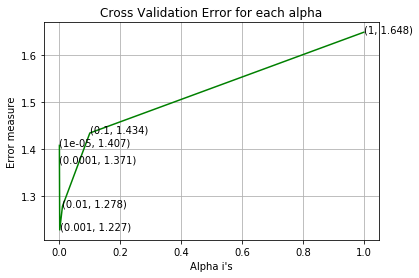

For values of best alpha =  0.001 The train log loss is: 0.7797225183599542
For values of best alpha =  0.001 The cross validation log loss is: 1.2273048338394041
For values of best alpha =  0.001 The test log loss is: 1.1603900679060428


In [118]:
# Text features are one-hot encoded

alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [119]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.619 % of word of test data appeared in train data
98.421 % of word of Cross Validation appeared in train data


### Preparing Data for Machine Learning Models

In [120]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [121]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [122]:
# Merging gene, variance and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)
print('#'*80)

print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2125, 54903)
(number of data points * number of features) in test data =  (665, 54903)
(number of data points * number of features) in cross validation data = (532, 54903)
################################################################################
 Response encoding features :
(number of data points * number of features) in train data =  (2125, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## K-Nearest Neighbour Classifier

### Hyper Parameter Tuning

for alpha = 5
Log Loss : 1.0860047918531734
for alpha = 11
Log Loss : 1.0673160003295774
for alpha = 15
Log Loss : 1.080786558433753
for alpha = 21
Log Loss : 1.080994845357324
for alpha = 31
Log Loss : 1.0920625220061417
for alpha = 41
Log Loss : 1.1031050700615954
for alpha = 51
Log Loss : 1.1005546707631937
for alpha = 99
Log Loss : 1.1210904927966456


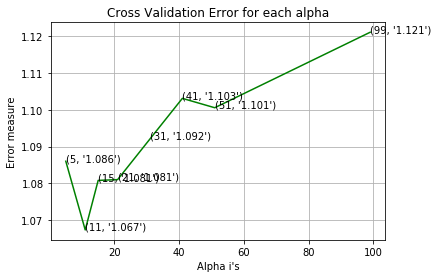

For values of best alpha =  11 The train log loss is: 0.6339093096506505
For values of best alpha =  11 The cross validation log loss is: 1.0673160003295774
For values of best alpha =  11 The test log loss is: 1.0428134690560276


In [123]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0673160003295774
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


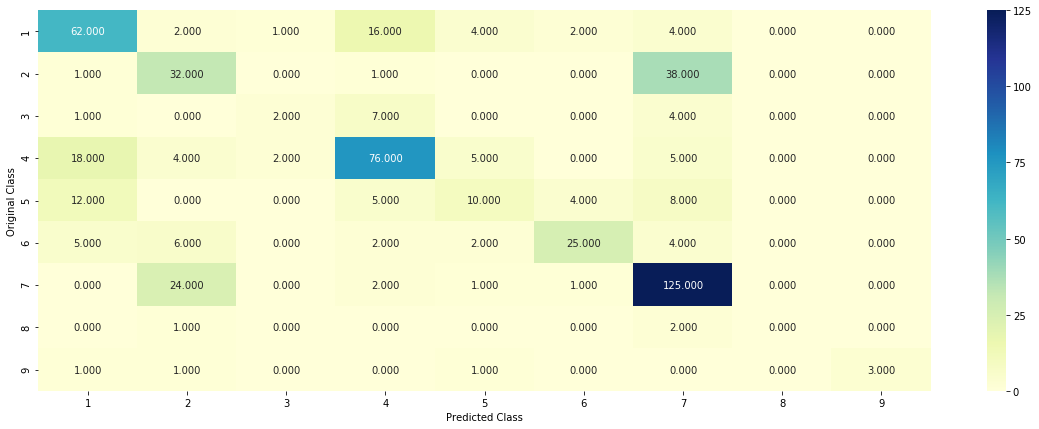

-------------------- Precision matrix (Columm Sum=1) --------------------


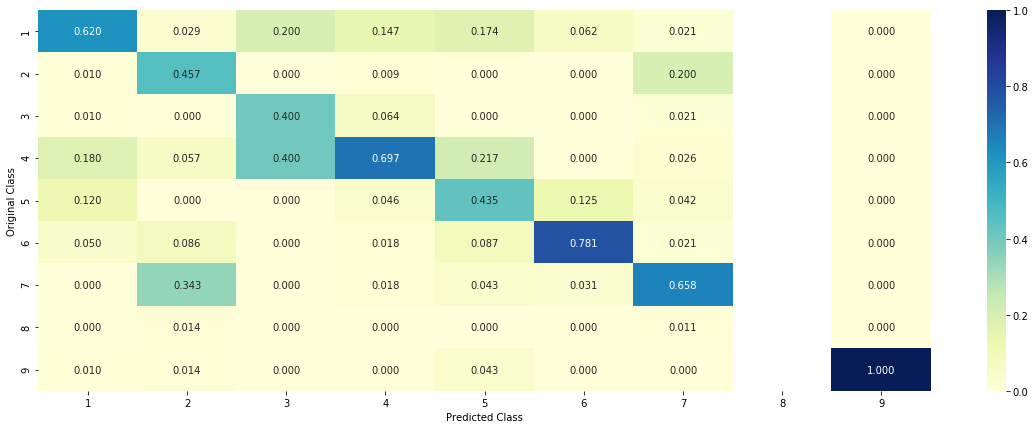

-------------------- Recall matrix (Row sum=1) --------------------


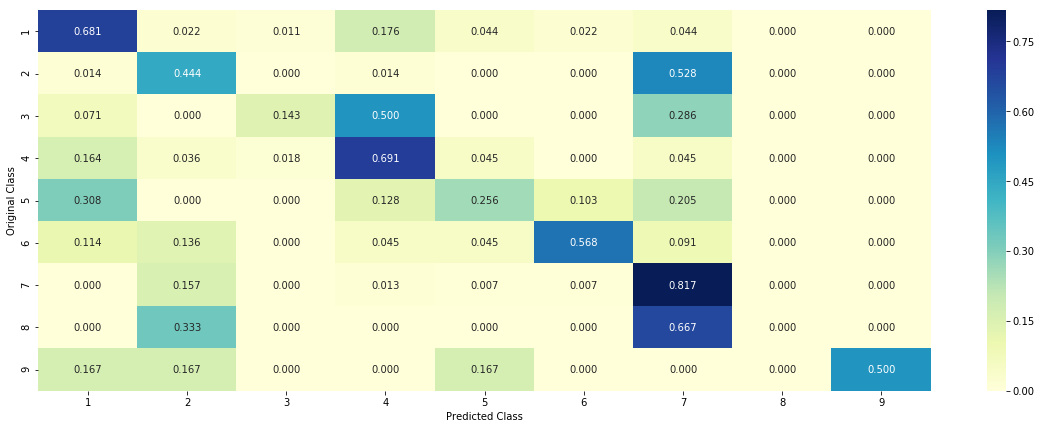

In [124]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [125]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [7 2 2 7 7 2 2 7 7 7 7]
Fequency of nearest points : Counter({7: 7, 2: 4})


In [126]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [7 7 7 7 7 7 7 7 2 2 7]
Fequency of nearest points : Counter({7: 9, 2: 2})


## Logistic Regression

### 1. Class Balancing

### Hyper Parameter Tuning

for alpha = 1e-06
Log Loss : 1.4111243639355666
for alpha = 1e-05
Log Loss : 1.4007058928732603
for alpha = 0.0001
Log Loss : 1.3651944961287061
for alpha = 0.001
Log Loss : 1.1593501769674794
for alpha = 0.01
Log Loss : 1.2021763623270922
for alpha = 0.1
Log Loss : 1.477865800392054
for alpha = 1
Log Loss : 1.6818535944276711
for alpha = 10
Log Loss : 1.704961789236435
for alpha = 100
Log Loss : 1.7073318905070176


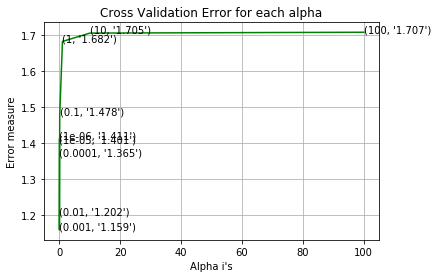

For values of best alpha =  0.001 The train log loss is: 0.6270480217733662
For values of best alpha =  0.001 The cross validation log loss is: 1.1593501769674794
For values of best alpha =  0.001 The test log loss is: 1.0792743968757843


In [169]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1593501769674794
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


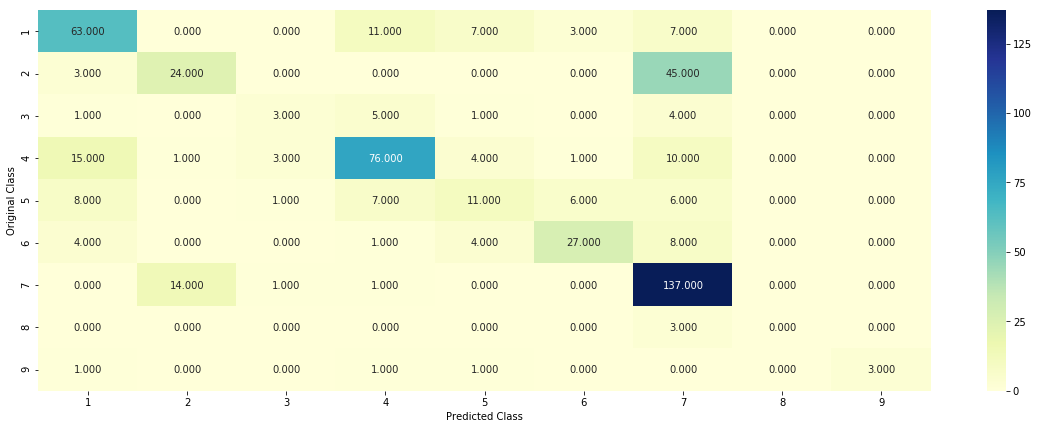

-------------------- Precision matrix (Columm Sum=1) --------------------


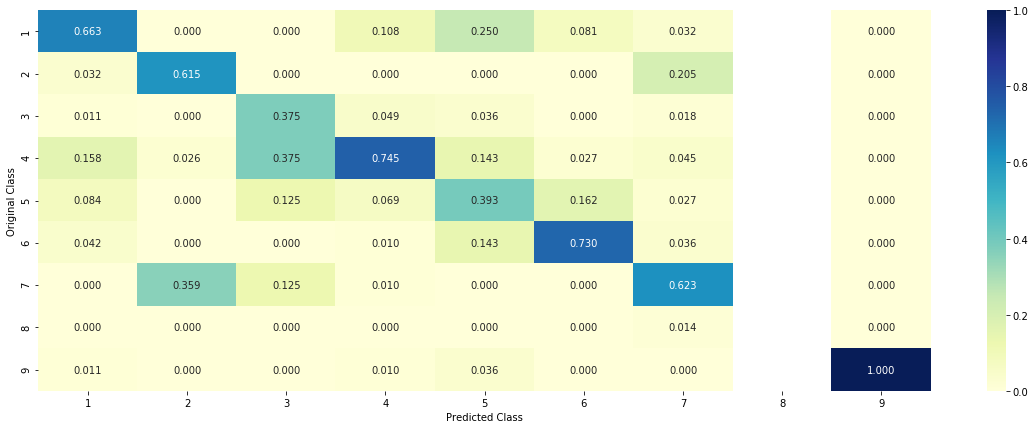

-------------------- Recall matrix (Row sum=1) --------------------


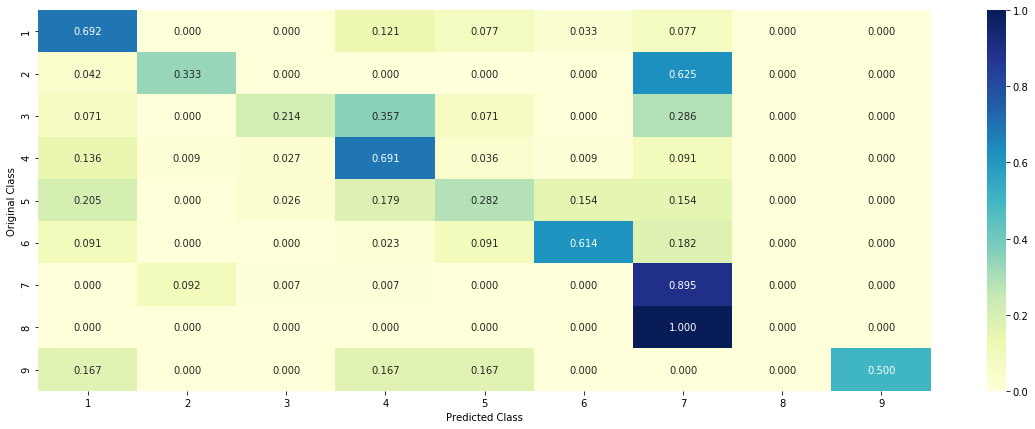

In [170]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [171]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if (i < train_gene_feature_onehotCoding.shape[1]):
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [172]:
#from tabulate import tabulate

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
#indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
#print("-"*50)
#get_imp_feature_names(indices[0], [test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index], test_df['Variation'].iloc[test_point_index]], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0899 0.1083 0.0035 0.0961 0.0295 0.0101 0.6505 0.0071 0.005 ]]
Actual Class : 7


In [156]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_imp_feature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1152 0.174  0.0198 0.1459 0.0579 0.0506 0.4263 0.0048 0.0056]]
Actual Class : 7
--------------------------------------------------


### 2. Without Class Imbalancing

### Hyper Parameter Tuning

for alpha = 1e-06
Log Loss : 1.3947503973736837
for alpha = 1e-05
Log Loss : 1.3908686540757826
for alpha = 0.0001
Log Loss : 1.3422829165930208
for alpha = 0.001
Log Loss : 1.1819548721216744
for alpha = 0.01
Log Loss : 1.2273093055194113
for alpha = 0.1
Log Loss : 1.3489882116469822
for alpha = 1
Log Loss : 1.5944382974171927


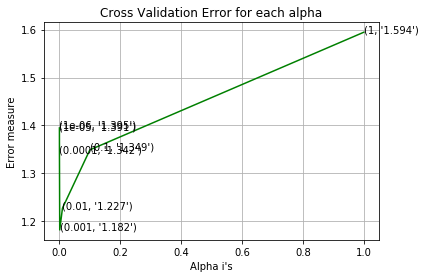

For values of best alpha =  0.001 The train log loss is: 0.6249234652679821
For values of best alpha =  0.001 The cross validation log loss is: 1.1819548721216744
For values of best alpha =  0.001 The test log loss is: 1.1079955980127951


In [147]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1819548721216744
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


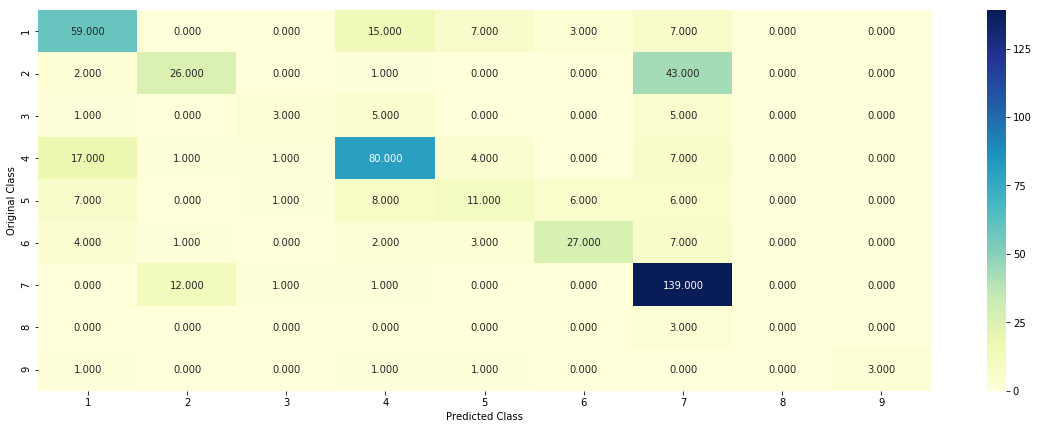

-------------------- Precision matrix (Columm Sum=1) --------------------


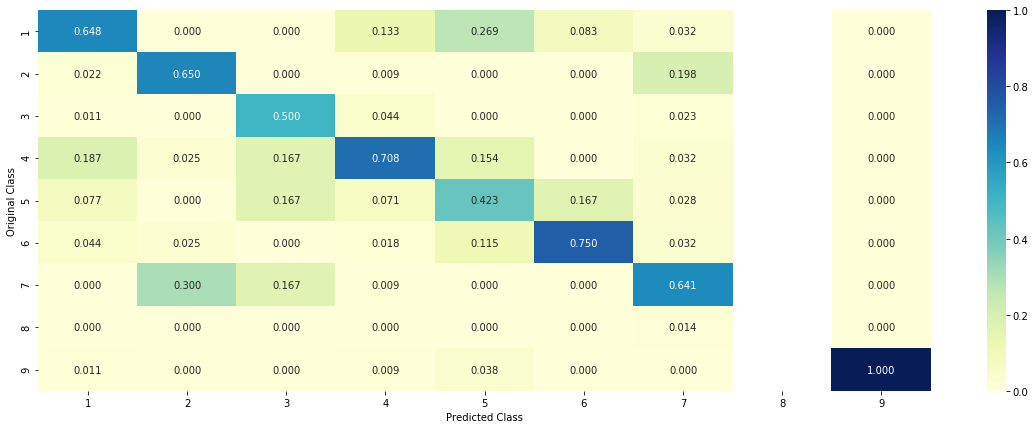

-------------------- Recall matrix (Row sum=1) --------------------


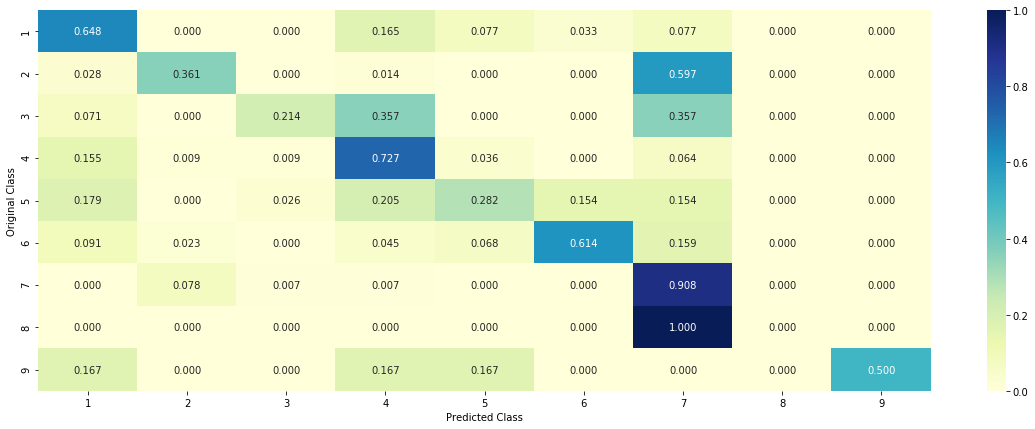

In [148]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


In [157]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
#indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
#print("-"*50)
#get_imp_feature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.122  0.1301 0.0104 0.137  0.0443 0.0187 0.5274 0.0058 0.0044]]
Actual Class : 7


In [159]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
#print("-"*50)
#get_imp_feature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1152 0.174  0.0198 0.1459 0.0579 0.0506 0.4263 0.0048 0.0056]]
Actual Class : 7


## Linear Support Vector Machine Classifier

### Hyper Parameter Tuning

for C = 1e-05
Log Loss : 1.4246743369109298
for C = 0.0001
Log Loss : 1.4013103228398103
for C = 0.001
Log Loss : 1.2717612820526256
for C = 0.01
Log Loss : 1.1639800419635327
for C = 0.1
Log Loss : 1.403739288960323
for C = 1
Log Loss : 1.6989933455939998
for C = 10
Log Loss : 1.707704011343375
for C = 100
Log Loss : 1.7077040064627793


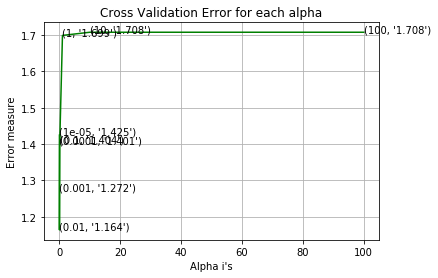

For values of best alpha =  0.01 The train log loss is: 0.7693420910480119
For values of best alpha =  0.01 The cross validation log loss is: 1.1639800419635327
For values of best alpha =  0.01 The test log loss is: 1.1230721307260838


In [153]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1639800419635327
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


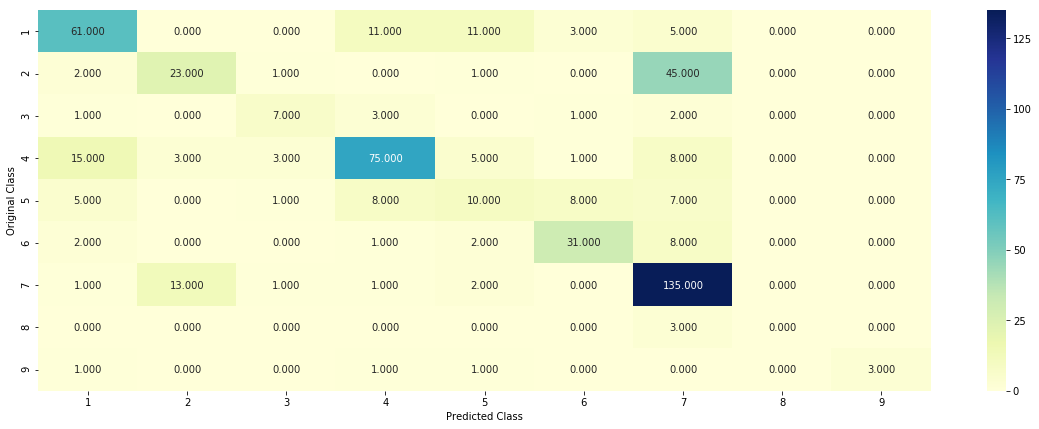

-------------------- Precision matrix (Columm Sum=1) --------------------


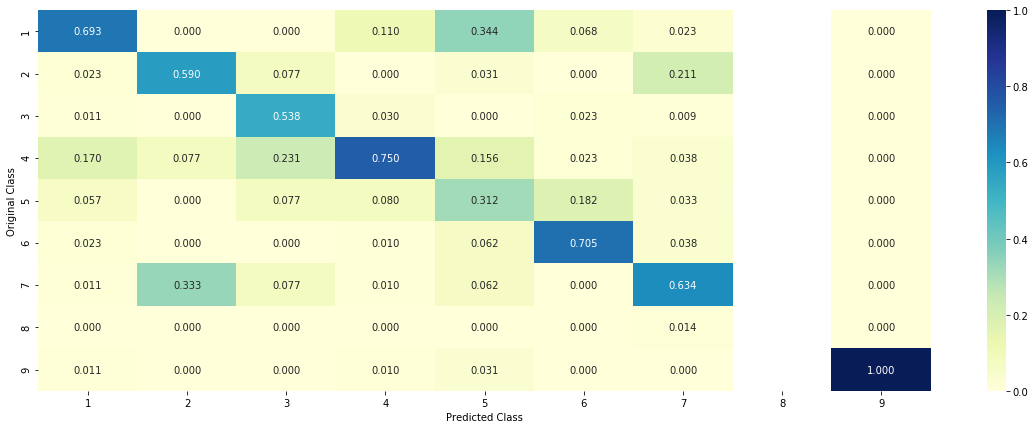

-------------------- Recall matrix (Row sum=1) --------------------


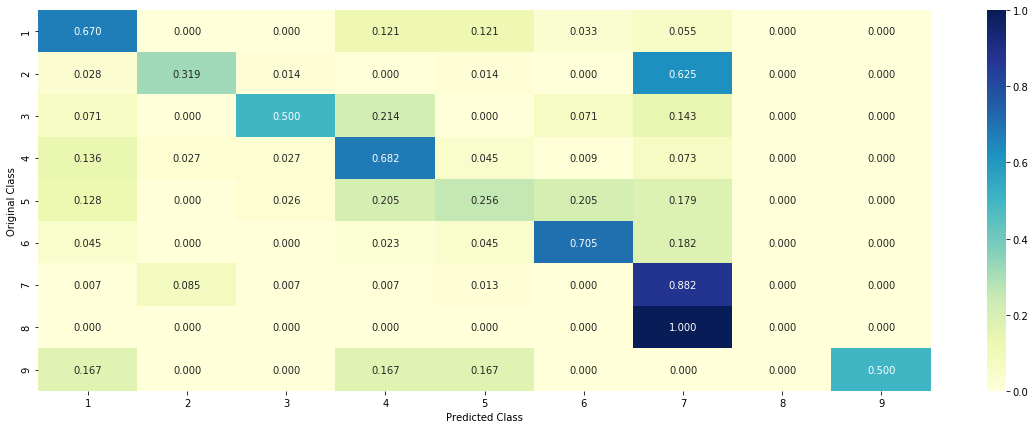

In [160]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [161]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
#indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
#print("-"*50)
#get_imp_feature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.122  0.1301 0.0104 0.137  0.0443 0.0187 0.5274 0.0058 0.0044]]
Actual Class : 7


In [162]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
#print("-"*50)
#get_imp_feature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1152 0.174  0.0198 0.1459 0.0579 0.0506 0.4263 0.0048 0.0056]]
Actual Class : 7


## Random Forest Classifier

### Hyper Parameter Tuning with One Hot Encoding

In [163]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2475677952035367
for n_estimators = 100 and max depth =  10
Log Loss : 1.1886145283191456
for n_estimators = 200 and max depth =  5
Log Loss : 1.2331519621081697
for n_estimators = 200 and max depth =  10
Log Loss : 1.1861315300416808
for n_estimators = 500 and max depth =  5
Log Loss : 1.2164712007940608
for n_estimators = 500 and max depth =  10
Log Loss : 1.1714433413781509
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2160840848370293
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1681280995462238
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2171446631494367
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1673067014016099
For values of best estimator =  2000 The train log loss is: 0.7183174606540086
For values of best estimator =  2000 The cross validation log loss is: 1.1673067014016096
For values of best estimator =  2000 The test log loss is: 1.171757685338684


Log loss : 1.6064622924089786
Number of mis-classified points : 0.5451127819548872
-------------------- Confusion matrix --------------------


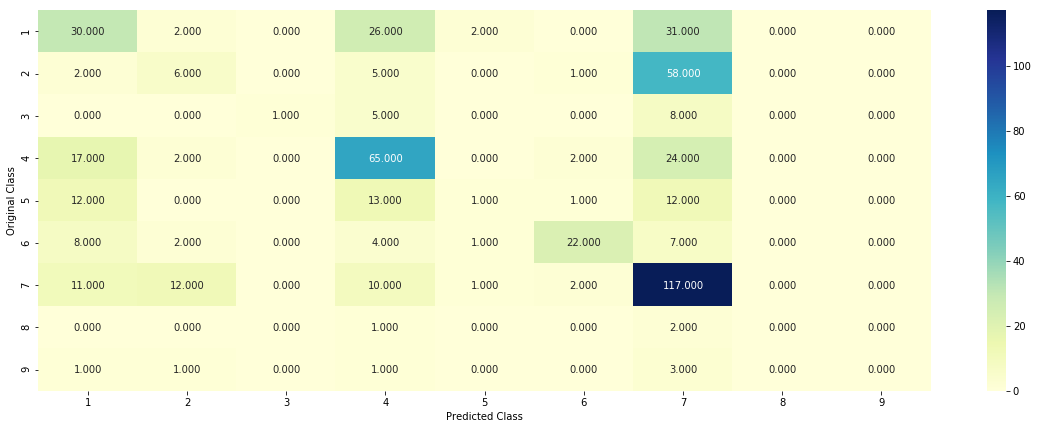

-------------------- Precision matrix (Columm Sum=1) --------------------


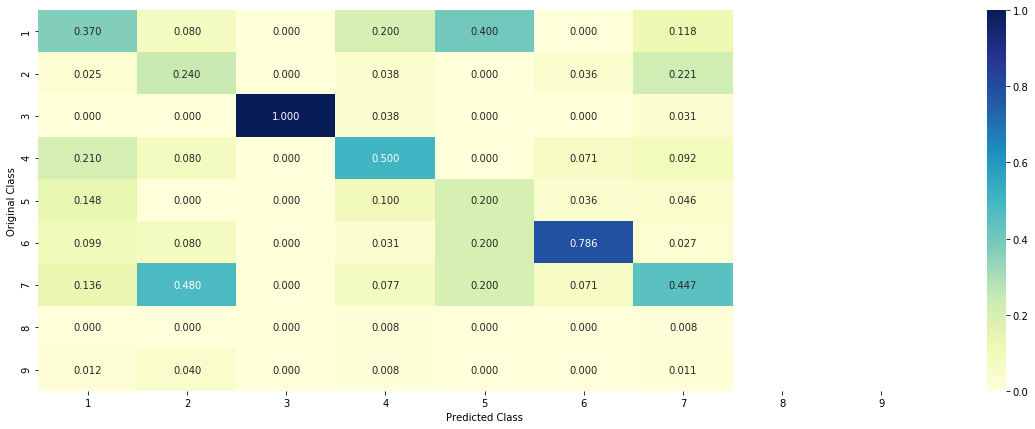

-------------------- Recall matrix (Row sum=1) --------------------


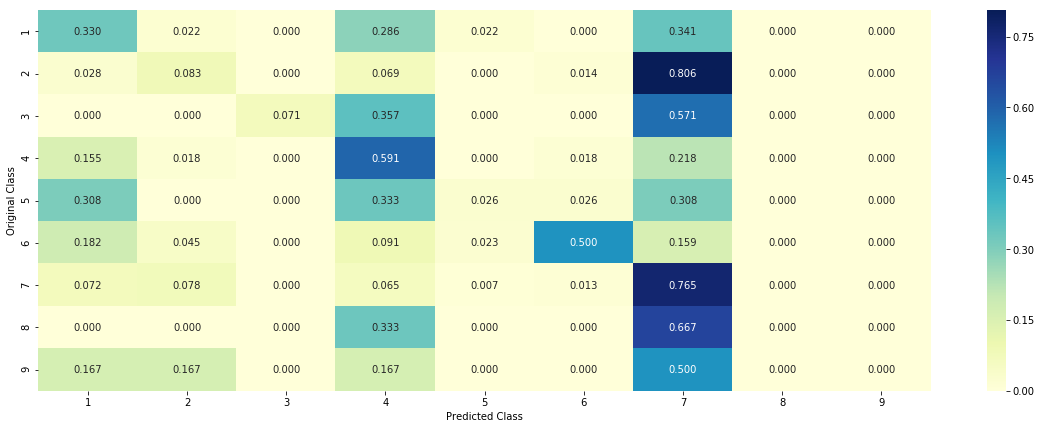

In [179]:
clf = RandomForestClassifier(n_estimators=int(alpha[int(best_alpha/2)])+1, criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [181]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=int(alpha[int(best_alpha/2)])+1, criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
#indices = np.argsort(-clf.feature_importances_)
#print("-"*50)
#get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1219 0.1241 0.0226 0.1116 0.0588 0.236  0.3109 0.0057 0.0085]]
Actual Class : 7


In [182]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
#indices = np.argsort(-clf.feature_importances_)
#print("-"*50)
#get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.149  0.1377 0.0259 0.1898 0.0617 0.0556 0.3644 0.0064 0.0097]]
Actuall Class : 7


### Hyper Parameter Tuning with Response Coding

In [183]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.9250690752672854
for n_estimators = 10 and max depth =  3
Log Loss : 1.6719203594950187
for n_estimators = 10 and max depth =  5
Log Loss : 1.6092145719689268
for n_estimators = 10 and max depth =  10
Log Loss : 1.8285819857608172
for n_estimators = 50 and max depth =  2
Log Loss : 1.6051379606748002
for n_estimators = 50 and max depth =  3
Log Loss : 1.377456568533607
for n_estimators = 50 and max depth =  5
Log Loss : 1.3936865852690636
for n_estimators = 50 and max depth =  10
Log Loss : 1.6292382355854733
for n_estimators = 100 and max depth =  2
Log Loss : 1.476798776784913
for n_estimators = 100 and max depth =  3
Log Loss : 1.4183217623861986
for n_estimators = 100 and max depth =  5
Log Loss : 1.333627926974731
for n_estimators = 100 and max depth =  10
Log Loss : 1.6331862800285695
for n_estimators = 200 and max depth =  2
Log Loss : 1.5603269875089367
for n_estimators = 200 and max depth =  3
Log Loss : 1.4099281570294953


Log loss : 1.333627926974731
Number of mis-classified points : 0.5375939849624061
-------------------- Confusion matrix --------------------


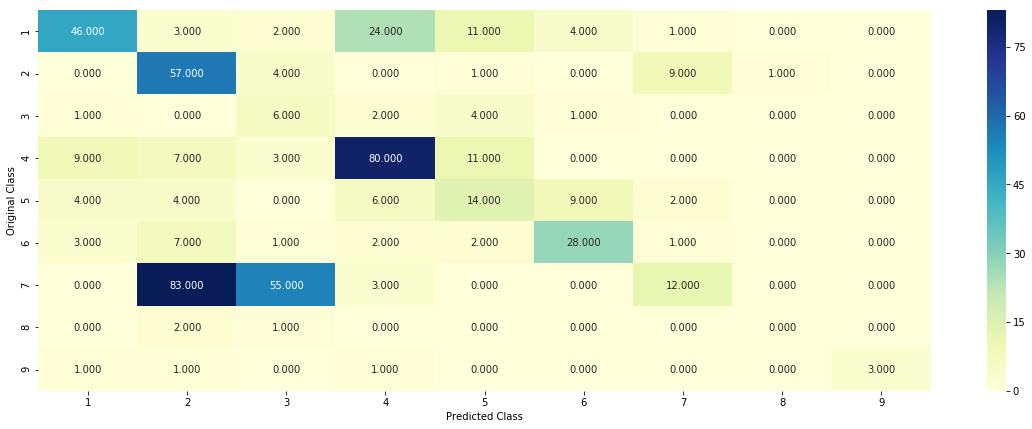

-------------------- Precision matrix (Columm Sum=1) --------------------


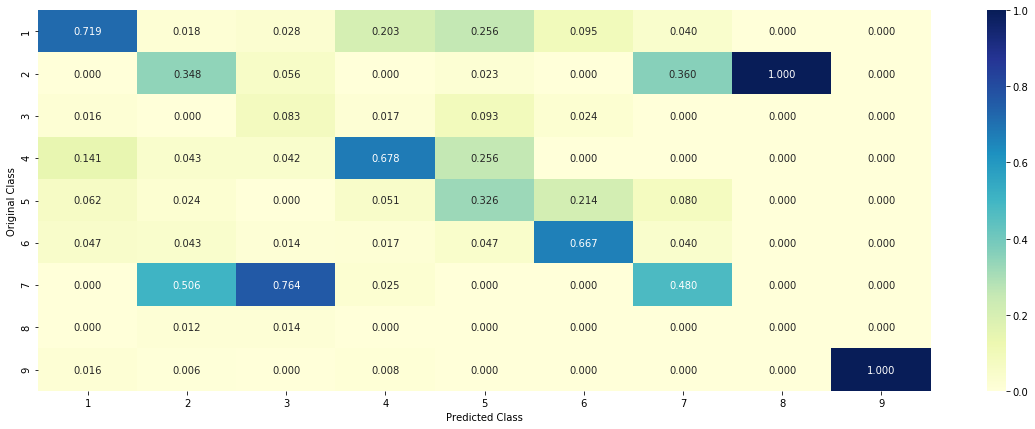

-------------------- Recall matrix (Row sum=1) --------------------


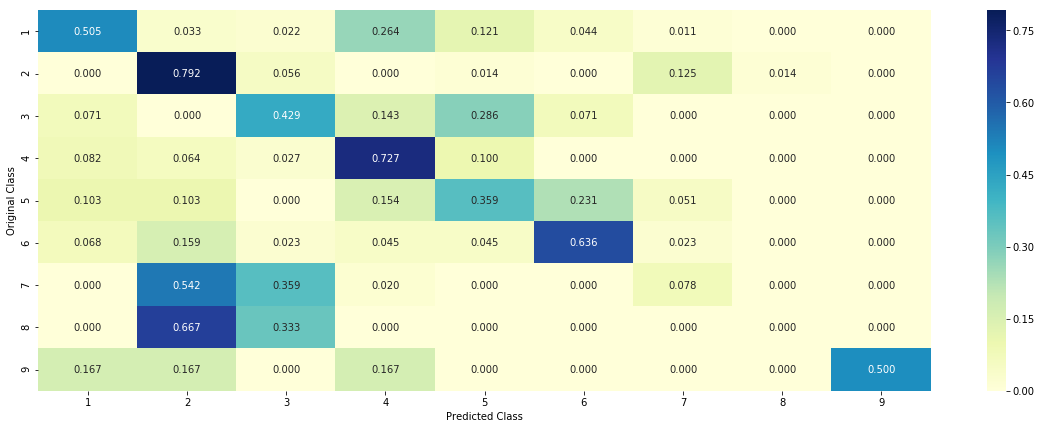

In [184]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [185]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0237 0.4333 0.2189 0.0339 0.0375 0.037  0.1673 0.0175 0.0309]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [186]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0146 0.3141 0.3307 0.0214 0.026  0.0272 0.2439 0.0094 0.0128]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
